In [1]:
import fiona
import shapely
from shapely.geometry import Point, LineString
from shapely.ops import unary_union
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#shapely.speedups.disable()

## Hourly tidal data generation from max min value

In [2]:
data = pd.read_excel(r"D:\CEGIS PROJECT\DWASA_masterplan_meghna\data\Hydrology Wasa\rawdata\WL74.xlsx", sheet_name=1)

In [3]:
data.head()

,STATIONID,DATETIME,High,Low
0,74,2018-01-01,2.40,2.11
1,74,2018-01-02,2.45,2.10
2,74,2018-01-03,2.46,2.10
3,74,2018-01-04,2.49,2.08
4,74,2018-01-05,2.49,2.08


In [4]:
data['Hour'] = data.apply(lambda x: x['DATETIME'].hour, axis=1)
data['Month'] = data.apply(lambda x: x['DATETIME'].month, axis=1)
data['Day'] = data.apply(lambda x: x['DATETIME'].day, axis=1)

In [5]:
data_flt = data.copy()#data[data['Year']==2020].copy().sort_values(by='DATETIME').copy()

### Filling empty cells with previous year data

In [6]:
#data[data['Year']==2019]

In [13]:
for idx,row in data_flt[np.isnan(data_flt['High'])].iterrows():
    dts = data[(data['Year']==2018) & (data['Month']==row['Month']) & (data['Day']==row['Day'])]
    print(row['Month'],row['Day'], dts['High'].to_list()[0], dts['Low'].to_list()[0])
    data_flt.loc[idx,'High'] = dts['High'].to_list()[0]
    data_flt.loc[idx,'Low'] = dts['Low'].to_list()[0]

In [8]:
#df.sort_values(by='col1', ascending=False)

In [14]:
data_flt

,STATIONID,DATETIME,High,Low,Hour,Month,Day
0,74,2018-01-01,2.40,2.11,0,1,1
1,74,2018-01-02,2.45,2.10,0,1,2
2,74,2018-01-03,2.46,2.10,0,1,3
3,74,2018-01-04,2.49,2.08,0,1,4
4,74,2018-01-05,2.49,2.08,0,1,5
...,...,...,...,...,...,...,...
360,74,2018-12-27,2.26,1.90,0,12,27
361,74,2018-12-28,2.27,1.90,0,12,28
362,74,2018-12-29,2.28,1.89,0,12,29
363,74,2018-12-30,2.30,1.90,0,12,30


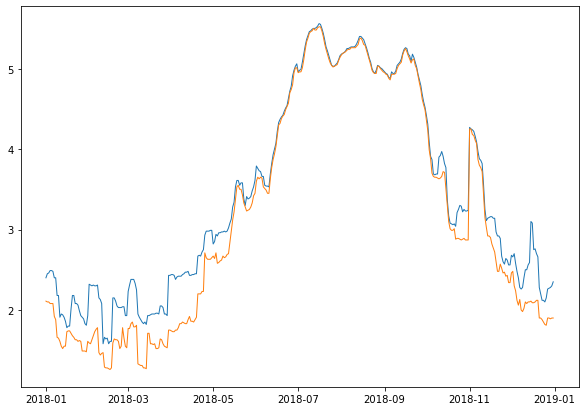

In [15]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
ax.plot(data_flt['DATETIME'], data_flt['High'], lw=1)
ax.plot(data_flt['DATETIME'], data_flt['Low'], lw=1)

In [16]:
data_flt.head()

,STATIONID,DATETIME,High,Low,Hour,Month,Day
0,74,2018-01-01,2.40,2.11,0,1,1
1,74,2018-01-02,2.45,2.10,0,1,2
2,74,2018-01-03,2.46,2.10,0,1,3
3,74,2018-01-04,2.49,2.08,0,1,4
4,74,2018-01-05,2.49,2.08,0,1,5


In [17]:
phaseData = pd.DataFrame({
    'DateTime':pd.date_range(start='1/1/2018', end='12/31/2018', freq='1H')})

In [18]:
phaseData['Hour'] = phaseData.apply(lambda x: x['DateTime'].hour, axis=1)
phaseData['Month'] = phaseData.apply(lambda x: x['DateTime'].month, axis=1)
phaseData['Day'] = phaseData.apply(lambda x: x['DateTime'].day, axis=1)

In [19]:
phaseData['radian'] = phaseData.apply(lambda x: x['Hour']*2*np.pi/12, axis=1)
phaseData['High'] = np.nan
phaseData['Low'] = np.nan
#phaseData.iloc[20:40]

In [20]:
for idx, row in phaseData.iterrows():
    dtst = data_flt[(data_flt['Month']==row['Month'])&(data_flt['Day']==row['Day'])]
    hvl = dtst['High'].to_list()[0]
    lvl = dtst['Low'].to_list()[0]
    phaseData.loc[idx, 'High'] = hvl
    phaseData.loc[idx, 'Low'] = lvl
    #print(dtst['High'].to_list()[0], dtst['Low'].to_list()[0])

In [21]:
phaseData['avg'] = phaseData.apply(lambda x: (x['High']+x['Low'])/2, axis=1)

In [22]:
phaseData['dataGen'] = phaseData.apply(lambda x: (0.5*(x['High']-x['Low'])*np.sin(x['radian']))+x['avg'], axis=1)
#phaseData['dataGen'] = phaseData.apply(lambda x: (0.5*(x['High']-x['Low'])*np.sin(x['radian']))+x['avg'], axis=1)
phaseData['sinData'] = phaseData.apply(lambda x: np.sin(x['radian']), axis=1)

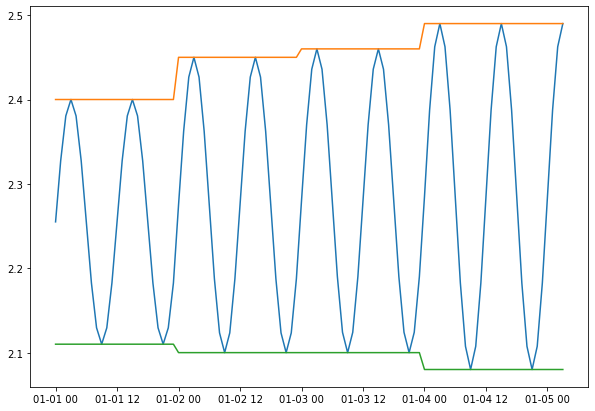

In [23]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
ran = 100
#ax.plot(phaseData['DateTime'].iloc[:ran],phaseData['sinData'].iloc[:ran])
ax.plot(phaseData['DateTime'].iloc[:ran],phaseData['dataGen'].iloc[:ran])
ax.plot(phaseData['DateTime'].iloc[:ran],phaseData['High'].iloc[:ran])
ax.plot(phaseData['DateTime'].iloc[:ran],phaseData['Low'].iloc[:ran])

In [24]:
phaseData

,DateTime,Hour,Month,Day,radian,High,Low,avg,dataGen,sinData
0,2018-01-01 00:00:00,0,1,1,0.000000,2.40,2.11,2.255,2.255000,0.000000
1,2018-01-01 01:00:00,1,1,1,0.523599,2.40,2.11,2.255,2.327500,0.500000
2,2018-01-01 02:00:00,2,1,1,1.047198,2.40,2.11,2.255,2.380574,0.866025
3,2018-01-01 03:00:00,3,1,1,1.570796,2.40,2.11,2.255,2.400000,1.000000
4,2018-01-01 04:00:00,4,1,1,2.094395,2.40,2.11,2.255,2.380574,0.866025
...,...,...,...,...,...,...,...,...,...,...
8732,2018-12-30 20:00:00,20,12,30,10.471976,2.30,1.90,2.100,1.926795,-0.866025
8733,2018-12-30 21:00:00,21,12,30,10.995574,2.30,1.90,2.100,1.900000,-1.000000
8734,2018-12-30 22:00:00,22,12,30,11.519173,2.30,1.90,2.100,1.926795,-0.866025
8735,2018-12-30 23:00:00,23,12,30,12.042772,2.30,1.90,2.100,2.000000,-0.500000


In [56]:
phaseData.to_excel(r"D:\CEGIS PROJECT\DWASA_masterplan_meghna\data\Hydrology Wasa\rawdata\genHourlyDilalpur.xlsx")